# Modeling

In [90]:
# load libraries

import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
%matplotlib inline
import altair as alt

from sklearn.cluster import KMeans, dbscan 
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

alt.renderers.enable("notebook")
np.random.seed(42)

In [91]:
path_data = './data/data_101219.geojson'

data = gpd.read_file(path_data)

### Aqueduct attributes for clustering

Baseline water stress: bws_raw  
Baseline water depletion: bwd_raw  
Interannual variability: iav_raw  
Seasonal variability: sev_raw  
Groundwater table decline: gtd_raw  
Riverine flood risk: rfr_raw  
Coastal flood risk: cfr_raw  
Drought risk: drr_raw  
Untreated connected wastewater: ucw_raw  
Unimproved/no drinking water: udw_raw  
Unimproved/no sanitation: usa_raw  

In [92]:
pd.set_option('display.max_columns', None)
data.head(1)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry
0,111011-EGY.11_1-3365,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.01057,0.023176,34.693151,2.522154,0.0,(POLYGON ((31.90590570688292 29.85788702426048...


## Convert polygons to points

#### We are goint to use DBScan to make our clusters. First, we select only valid geometries and convert the CRS to 6933, to have the coordinates in meters. Then we convert the geometries into points and extract separately the 'x' and 'y' coordinates.

In [93]:
data.shape

(68506, 16)

In [94]:
data.geometry.type[0]

'MultiPolygon'

In [95]:
data = data[data.geometry.type == 'MultiPolygon']
data.shape

(68497, 16)

In [65]:
# data = data.to_crs({'init': 'epsg:6933'})

In [96]:
data_point = data.copy()
data_point.geometry = data_point['geometry'].centroid

In [97]:
data_point.head(5)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry
0,111011-EGY.11_1-3365,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.01057,0.023176,34.693151,2.522154,0.000000,POINT (31.89703994079558 29.84799469022497)
1,111011-EGY.15_1-3365,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.01057,0.023176,14.868493,13.672038,1506.964639,POINT (32.24300482987483 29.87819768900844)
2,111011-EGY.15_1-None,2.318042,0.987061,1.035414,0.962396,NaN,0.074383,0.0,NaN,0.6139,0.01057,0.023176,14.868493,36.785975,12130.427165,POINT (32.45095368637701 29.81223771833924)
3,111011-None-3365,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,NaN,0.01057,0.023176,14.868493,35.409092,0.000000,POINT (32.4796340525661 29.86759208874758)
4,111011-None-None,2.318042,0.987061,1.035414,0.962396,NaN,0.074383,0.0,NaN,NaN,0.01057,0.023176,14.868493,38.731335,932.199402,POINT (32.4436295957421 29.80798488045403)


In [98]:
data_point['x'] = data_point.geometry.x
data_point['y'] = data_point.geometry.y
data_point.head(5)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,x,y
0,111011-EGY.11_1-3365,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.01057,0.023176,34.693151,2.522154,0.000000,POINT (31.89703994079558 29.84799469022497),31.897040,29.847995
1,111011-EGY.15_1-3365,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.01057,0.023176,14.868493,13.672038,1506.964639,POINT (32.24300482987483 29.87819768900844),32.243005,29.878198
2,111011-EGY.15_1-None,2.318042,0.987061,1.035414,0.962396,NaN,0.074383,0.0,NaN,0.6139,0.01057,0.023176,14.868493,36.785975,12130.427165,POINT (32.45095368637701 29.81223771833924),32.450954,29.812238
3,111011-None-3365,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,NaN,0.01057,0.023176,14.868493,35.409092,0.000000,POINT (32.4796340525661 29.86759208874758),32.479634,29.867592
4,111011-None-None,2.318042,0.987061,1.035414,0.962396,NaN,0.074383,0.0,NaN,NaN,0.01057,0.023176,14.868493,38.731335,932.199402,POINT (32.4436295957421 29.80798488045403),32.443630,29.807985


# Create Pipeline

1. Imputation option for missing data: https://scikit-learn.org/stable/modules/impute.html
1. Standard scaler
1. kmeans
1. optimize K using elbow method: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
1. generate final clusters
1. join clusters back to original data (unscaled)
1. summarise means for each group
1. describe group typologies

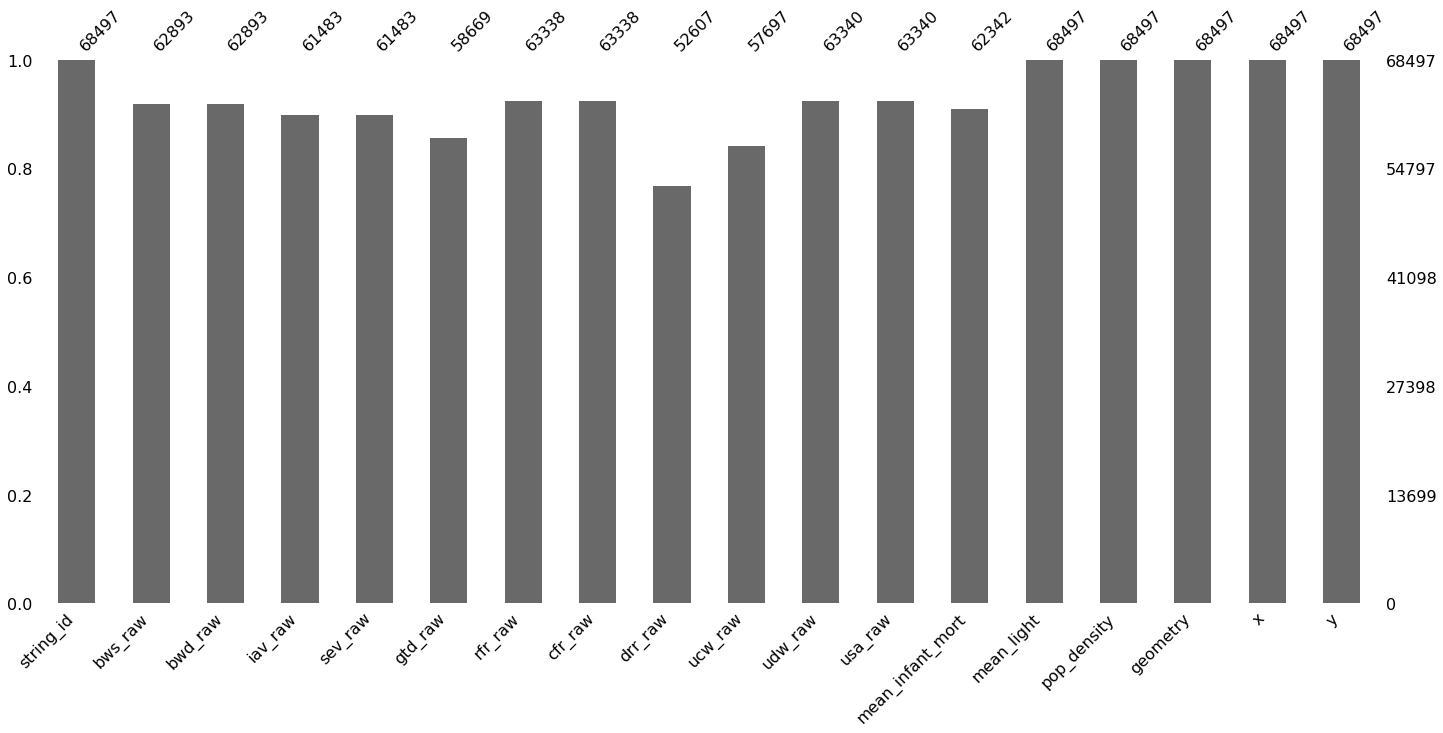

In [69]:
import missingno as msno
msno.bar(data_point)

## Dropping all NA Values

In [99]:
data_nona = data_point.dropna()
data_nona.shape

(42823, 18)

## Scaling the values

In [100]:
scaler = StandardScaler()

In [101]:
data_scaled = data_nona.copy()
data_scaled = data_scaled.drop(['string_id', 'geometry', 'x', 'y'], axis=1)
col_names = list(data_scaled.columns)

In [102]:
data_scaled = pd.DataFrame(scaler.fit_transform(data_scaled))
data_scaled.columns = col_names
data_scaled.head()

,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density
0,-0.004001,-0.01858,0.049857,1.805647,0.609039,5.620707,-0.062046,-0.094333,-2.27507,0.614729,1.706679,0.510622,-0.375813,-0.184027
1,-0.004001,-0.01858,0.049857,1.805647,0.609039,5.620707,-0.062046,-0.094333,-2.27507,0.614729,1.706679,0.981404,-0.364078,-0.184027
2,-0.004001,-0.01858,0.049857,1.805647,0.025061,5.620707,-0.062046,-0.094333,-2.27507,0.614729,1.706679,0.735557,-0.348646,-0.148502
3,-0.004001,-0.01858,0.049857,1.805647,-0.059627,5.620707,-0.062046,-0.094333,-2.27507,0.614729,1.706679,0.735557,-0.340406,-0.151690
4,-0.004001,-0.01858,0.049857,1.805647,0.609039,5.620707,-0.062046,-0.094333,-2.27507,0.614729,1.706679,0.736560,-0.361758,-0.171148


In [103]:
data_DBscan = data_nona[['x', 'y']].copy()
data_DBscan = data_DBscan.reset_index()
data_DBscan = data_DBscan.drop(['index'], axis = 1)
data_DBscan.head()

,x,y
0,38.022361,17.517010
1,37.894224,17.455719
2,37.544056,18.157662
3,37.712647,18.339959
4,37.647570,17.769759


In [104]:
data_DBscan = pd.concat([data_DBscan, data_scaled], axis = 1)
data_DBscan.head()

,x,y,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density
0,38.022361,17.517010,-0.004001,-0.01858,0.049857,1.805647,0.609039,5.620707,-0.062046,-0.094333,-2.27507,0.614729,1.706679,0.510622,-0.375813,-0.184027
1,37.894224,17.455719,-0.004001,-0.01858,0.049857,1.805647,0.609039,5.620707,-0.062046,-0.094333,-2.27507,0.614729,1.706679,0.981404,-0.364078,-0.184027
2,37.544056,18.157662,-0.004001,-0.01858,0.049857,1.805647,0.025061,5.620707,-0.062046,-0.094333,-2.27507,0.614729,1.706679,0.735557,-0.348646,-0.148502
3,37.712647,18.339959,-0.004001,-0.01858,0.049857,1.805647,-0.059627,5.620707,-0.062046,-0.094333,-2.27507,0.614729,1.706679,0.735557,-0.340406,-0.151690
4,37.647570,17.769759,-0.004001,-0.01858,0.049857,1.805647,0.609039,5.620707,-0.062046,-0.094333,-2.27507,0.614729,1.706679,0.736560,-0.361758,-0.171148


In [105]:
data_DBscan.shape

(42823, 16)

## Creating the Clusters

In [110]:
eps = 10000
min_samples = 5

cores, labels = dbscan(data_DBscan[["x", "y"]], eps=eps, min_samples=min_samples)

In [111]:
cores[:5]

array([0, 1, 2, 3, 4], dtype=int64)

In [112]:
print(len(cores))

42823
